# Anomaly Detection using Isolation Forest


Some algorithms such as Isolation Forest and SVM learn a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, tune themselves to identify the abnormalities that fall outside the learned region.

To use an Isolation Forest we need numeric variables. This would be considered a semisupervised learning technique. 

We also need to gather a sample of 'normal observations'.  We will start with observations that will be considered normal and will be used to train the model (training and scoring in Python’s scikit-learn implementation of Isolation Forest are analogous to all other machine learning algorithms). The second group are new observations

In this example, we will look for anomalies using 2 different variables:
- Using amount of data being pulled, in megabytes (size_mb), and the probability of the given IP requesting data, we will attempt to identify anomalous events. 

https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('data/anonymized-curriculum-access.txt.gz',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')

In [3]:
colnames=['cohort_id','cohort_name','start_date','end_date']
df_cohort = pd.read_csv('data/cohort_dates.csv',
                             names=colnames,
                             skiprows=1)

df = df.merge(df_cohort, on='cohort_id', how='left')
df = df[df.start_date >= '2018-01-26'].reset_index().drop(columns='index')

df['start_date'] = pd.to_datetime(df.start_date)
df['end_date'] = pd.to_datetime(df.end_date)
df['date'] = pd.to_datetime(df.date)
df.head()

,date,page_viewed,user_id,cohort_id,ip,cohort_name,start_date,end_date
0,2018-03-05,html-css/css-i,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
1,2018-03-05,html-css/forms,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
2,2018-03-05,html-css/css-i,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
3,2018-03-05,html-css/css-i/introduction,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19
4,2018-03-05,html-css,25,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19


In [4]:
# zero the cohorts to their start date
df['days_normalized'] = (df['date']-df['start_date']).dt.days

df = df.groupby(['user_id','cohort_name','days_normalized'])['page_viewed'].count().reset_index()

In [5]:
df.info()
df.head()
df.page_viewed.describe()
# pd.cut(df.days_normalized, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14910 entries, 0 to 14909
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          14910 non-null  int64 
 1   cohort_name      14910 non-null  object
 2   days_normalized  14910 non-null  int64 
 3   page_viewed      14910 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 466.1+ KB


count    14910.000000
mean        12.668410
std         12.968503
min          1.000000
25%          4.000000
50%          9.000000
75%         17.000000
max        272.000000
Name: page_viewed, dtype: float64

In [6]:
train = df[df.days_normalized<70][['days_normalized','page_viewed']]
test = df[(df['days_normalized']>=70) & (df['days_normalized']<140)][['days_normalized','page_viewed']]
outlier = df[df.days_normalized>=140][['days_normalized','page_viewed']]

<AxesSubplot:xlabel='days_normalized', ylabel='page_viewed'>

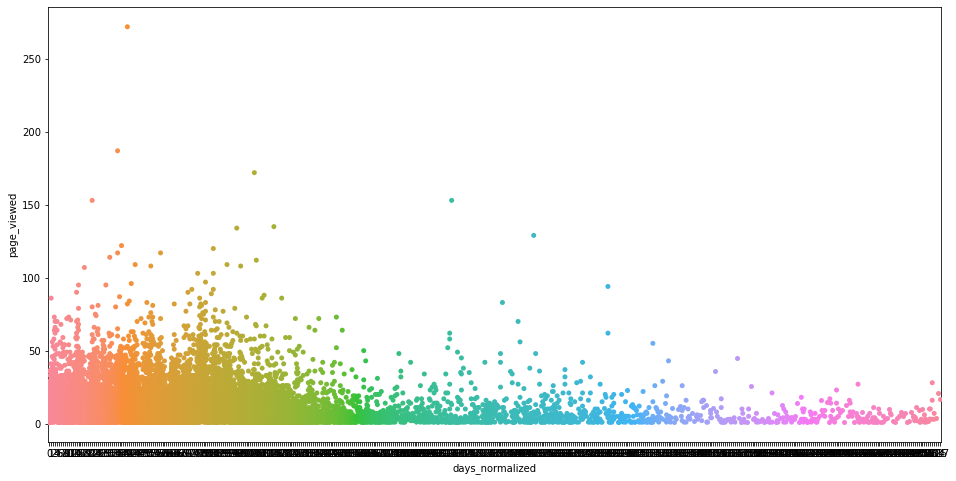

In [7]:
plt.figure(figsize=(16,8))
sns.swarmplot(df.days_normalized, df.page_viewed)

In [8]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

clf = IsolationForest(max_samples=10,
                      random_state=rng, contamination='auto')
clf.fit(train)
y_pred_train = clf.predict(train)
y_pred_test = clf.predict(test)
y_pred_outlier = clf.predict(outlier)

In [9]:
pd.DataFrame({'y_pred': y_pred_outlier}).y_pred.value_counts()

-1    1413
Name: y_pred, dtype: int64

In [10]:

def plot_clf(x, y, x_min, x_max, y_min, y_max, x_label, y_label):
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 25), np.linspace(y_min, y_max, 25))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    
    b1 = plt.scatter(train[x], train[y],
                     c='white',
                     s=20, 
                     edgecolor='k')
    b2 = plt.scatter(test[x], test[y], 
                     c='green',
                     s=20, 
                     edgecolor='k')
    b3 = plt.scatter(outlier[x], outlier[y],
                    c='red',
                    s=20,
                    edgecolor='k')
    plt.axis('tight')
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))
    plt.legend([b1, b2, b3],
               ["half1",
                "half2",
               "post_cohort"],
               loc="best")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.show()

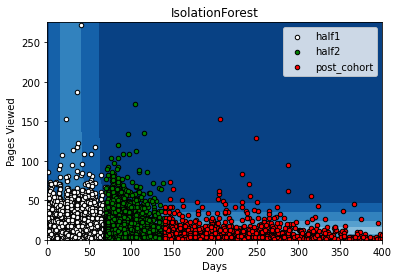

In [11]:
plot_clf('days_normalized', 'page_viewed', 0, 400, 0, 275, 'Days', 'Pages Viewed')